In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cap_df = pd.read_csv('top_cap.csv')
cap_df

,symbol,name,cap
0,BTCUSDT,Bitcoin,2161753983734
1,ETHUSDT,Ethereum,320295874606
2,USDTUSDT,Tether,155519706251
3,XRPUSDT,XRP,135839785268
4,BNBUSDT,BNB,96049768518
...,...,...,...
95,USDCUSDT,Binance Bridged USDC (BNB Smart Chain),999076348
96,METHUSDT,Mantle Staked Ether,991645352
97,XDCUSDT,XDC Network,975537662
98,ABUSDT,AB,972521767


In [3]:
df = pd.read_csv('data.csv')
df_vol = df[['timestamp', 'symbol', 'volume']].copy()

df_vol = df_vol.pivot(index='timestamp', columns='symbol', values='volume')
df_vol = df_vol.dropna(axis=1, how='any')
df_vol

symbol,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,...,SOLUSDT,STXUSDT,SUIUSDT,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-18,42817.257,65212614.6,24178383.0,4543641.48,35635277.9,897485.09,1329941.71,34258.436,359878.981,21538.31022,...,1603688.440,9044939.5,70237006.6,2.205534e+08,811568.95,1.337784e+08,198655987.0,2.97453,27780907.0,225020544.0
2023-06-19,50039.548,70893812.3,25084572.0,2830548.93,29777653.3,879121.04,1123434.72,22916.622,425074.269,35872.65974,...,1890318.270,15858994.1,70115654.4,2.039232e+08,912427.69,2.536328e+08,244626356.9,1.98481,23138226.0,322187608.0
2023-06-20,63899.431,109090810.6,24871528.0,3966378.64,66970269.6,1353659.52,1626750.24,39355.486,639069.672,69666.95525,...,3005581.720,59314289.2,85994336.2,3.500941e+08,1001445.09,4.432815e+08,280199803.2,16.50775,38186238.0,378325906.0
2023-06-21,100875.983,189786985.2,41814490.0,4624644.55,93746416.1,1678420.46,2738855.15,541394.240,1006328.557,108926.40412,...,4146918.990,67012108.6,94202270.2,3.843230e+08,1523320.50,5.427562e+08,387505087.2,17.06535,64042136.0,408749828.0
2023-06-22,106667.204,167726209.8,37603097.0,3638941.56,67981082.9,1394446.55,2240979.03,323358.509,1032630.471,59054.56460,...,3547312.430,49438262.7,86075057.7,2.801908e+08,1126010.49,4.093545e+08,578691180.7,4.39823,58491918.0,442729597.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,207729.733,99094622.1,55926046.0,3375675.49,67852671.3,1524166.99,2415966.59,37375.468,152793.975,17778.67218,...,2883476.685,5910086.5,43274878.5,5.746558e+08,8754894.92,1.413567e+09,254089414.1,96.02548,45285759.0,98220197.3
2025-06-13,529097.909,180308681.7,82148892.0,6834678.98,144835916.6,2528137.46,5203353.31,91918.580,223303.917,26180.81734,...,5339782.783,8718624.4,101351788.3,5.627748e+08,21627948.35,1.863984e+09,449599101.3,93.03717,101403507.0,171924272.9
2025-06-14,166336.995,57750191.8,24120411.0,2428687.95,50905874.8,920527.91,1096166.12,34424.810,93690.143,8798.93969,...,1679994.751,3802657.3,50089702.7,1.627638e+08,5833384.80,3.921939e+08,132838960.1,62.01518,25309710.0,67644610.7


In [4]:
df = df[['timestamp', 'symbol', 'close']]

df = df.pivot(index='timestamp', columns='symbol', values='close')
df = df.dropna(axis=1, how='any')

In [5]:
df

symbol,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,...,SOLUSDT,STXUSDT,SUIUSDT,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-18,50.93,0.2610,0.1150,6.7300,0.9943,8.568,11.34,107.0,244.10,26339.97,...,15.45,0.5551,0.7207,0.07016,4.482,1.0002,0.01486,26500.41,0.0795,0.4868
2023-06-19,51.96,0.2634,0.1165,6.9392,1.0073,8.599,11.47,106.8,243.10,26844.35,...,16.10,0.5933,0.7851,0.06999,4.481,1.0002,0.01516,26733.78,0.0800,0.4936
2023-06-20,53.10,0.2705,0.1214,7.2154,1.0834,8.770,12.12,110.0,247.70,28307.99,...,16.64,0.7491,0.8189,0.07057,4.572,0.9998,0.01559,28350.00,0.0827,0.4929
2023-06-21,55.02,0.2862,0.1258,7.4541,1.1405,9.038,12.90,135.9,248.80,29993.89,...,17.23,0.8189,0.8312,0.07233,4.772,1.0000,0.01642,30077.08,0.0868,0.4999
2023-06-22,55.60,0.2899,0.1248,7.3567,1.0873,9.002,12.65,133.5,240.80,29884.92,...,16.62,0.7746,0.8030,0.07226,4.732,0.9997,0.01686,30032.31,0.0867,0.4938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,293.92,0.6613,0.1805,4.6960,0.3660,4.214,20.28,424.0,654.75,105671.73,...,152.32,0.6480,3.2078,0.27180,7.489,0.9995,0.02342,105692.06,0.2673,2.1899
2025-06-13,291.17,0.6420,0.1808,4.4970,0.3487,4.131,19.41,448.7,655.35,106066.59,...,148.60,0.6370,3.0758,0.26970,7.759,0.9994,0.02260,106027.39,0.2608,2.1472
2025-06-14,275.11,0.6247,0.1771,4.4590,0.3333,4.087,18.93,430.9,645.61,105414.64,...,144.64,0.6270,2.9470,0.27110,7.302,0.9994,0.02206,105399.14,0.2564,2.1394


# Solver

In [6]:
def find_optimal_parameters(df, symbol_list=None, 
                            min_last_days=30, max_last_days=100, step_day=1,
                            min_procent=0.01, max_procent=0.5, step_procent=0.05,
                            min_std_procent=0.01, max_std_procent=0.2, step_std=0.01):
    results = {}

    if symbol_list is None:
        symbol_list = df.columns.tolist()

    for symbol in symbol_list:
        optimal_procent = max_procent
        optimal_last_days = min_last_days
        optimal_std_procent = max_std_procent

        for last_days in range(min_last_days, max_last_days + 1, step_day):
            df_slice = df[symbol].iloc[-last_days:]
            mean_val = df_slice.mean()
            df_warning_100 = df[symbol].iloc[-100:]
            df_warning_30 = df[symbol].iloc[-30:]

            for std_procent in np.arange(max_std_procent, min_std_procent, -step_std):
                std_n = mean_val * std_procent

                for procent in np.arange(max_procent, min_procent, -step_procent):
                    min_historical = df[symbol].min() * (procent + 1.0)
                    min_support_100 = df_warning_100.min() * (procent + 1.0)
                    min_support_30 = df_warning_30.min() * (procent + 1.0)
                    max_historical = df[symbol].max()
                    max_resist_100 = df_warning_100.max()
                    max_resist_30 = df_warning_30.max()

                    if df_slice.std() <= std_n and mean_val <= min_historical:
                        if (procent < optimal_procent or
                            (procent == optimal_procent and last_days > optimal_last_days) or
                            (procent == optimal_procent and last_days == optimal_last_days and std_procent < optimal_std_procent)):
                            optimal_procent = procent
                            optimal_last_days = last_days
                            optimal_std_procent = std_procent

        last_price = df[symbol].iloc[-1]

        if (optimal_procent == max_procent) & (optimal_last_days == min_last_days) & (optimal_std_procent == max_std_procent):
            continue

        results[symbol] = (optimal_procent, optimal_last_days, optimal_std_procent, 
                           min_support_100, min_support_30, min_historical, 
                           max_historical, max_resist_100, max_resist_30, 
                           last_price)

    results = pd.DataFrame(results).T
    results.columns = ['Optimal Procent', 'Optimal Last Days', 'Optimal Std Procent', 
                       'Min Support 100', 'Min Support 30', 'Min Historical', 
                       'Max Historical', 'Max Resist 100', 'Max Resist 30', 
                       'Last Price']
    results = results.sort_values(by=['Optimal Procent', 'Optimal Last Days', 'Optimal Std Procent'], 
                                    ascending=[True, False, False])

    return results

In [7]:
optimal_symbol = find_optimal_parameters(df, symbol_list=None,
                                         min_last_days=90, max_last_days=100, step_day=5,
                                         min_procent=0.01, max_procent=0.5, step_procent=0.01,
                                         min_std_procent=0.01, max_std_procent=0.2, step_std=0.01)

In [8]:
ignore_symbols = ['USDCUSDT', 'FDUSDUSDT']
optimal_symbol = optimal_symbol[~optimal_symbol.index.isin(ignore_symbols)]

In [9]:
optimal_symbol

,Optimal Procent,Optimal Last Days,Optimal Std Procent,Min Support 100,Min Support 30,Min Historical,Max Historical,Max Resist 100,Max Resist 30,Last Price
APTUSDT,0.19,95.0,0.09,4.43496,4.548180,4.43496,18.0702,6.1380,5.7150,4.8960
FILUSDT,0.21,100.0,0.09,2.31132,2.414340,2.31132,11.4520,3.2450,3.0850,2.5490
ETCUSDT,0.23,100.0,0.08,14.35140,16.615800,14.35140,38.2700,20.7000,19.6900,17.4800
OPUSDT,0.23,90.0,0.13,0.60180,0.601800,0.60180,4.6970,0.9210,0.8120,0.6150
DOTUSDT,0.25,100.0,0.10,3.44556,3.856620,3.44556,11.5580,5.3090,4.9480,3.9750
ATOMUSDT,0.26,100.0,0.09,3.65160,4.162620,3.65160,14.2220,5.3840,5.2190,4.2740
ARBUSDT,0.33,100.0,0.13,0.26979,0.329664,0.26979,2.2587,0.4842,0.4291,0.3381
ETHUSDT,0.43,100.0,0.19,1502.87820,2462.290200,1502.87820,4064.8000,2816.4000,2816.4000,2654.0600


In [10]:
result = optimal_symbol.head(5).index.to_list()

In [11]:
result

['APTUSDT', 'FILUSDT', 'ETCUSDT', 'OPUSDT', 'DOTUSDT']

# Побудова графіку

In [30]:
def paint_result(df, result, info_df, cap_df, volume_df, last_days=365):
    num_symbols = len(result)
    fig, axes = plt.subplots(nrows=num_symbols, ncols=1, figsize=(16, 6 * num_symbols), sharex=False)

    if num_symbols == 1:
        axes = [axes]

    for idx, symbol in enumerate(result):
        series = df[symbol].iloc[-last_days:]
        volume_series = volume_df[symbol].iloc[-last_days:]
        ax = axes[idx]

        # ==== Графік ціни ====
        series.plot(ax=ax, label='Price', color='blue')

        symbol_cap = cap_df[cap_df['symbol'] == symbol]['cap'].values[0] / 1_000_000_000
        min_support_100 = info_df.loc[symbol, 'Min Support 100']
        max_resist_100 = info_df.loc[symbol, 'Max Resist 100']
        min_support_30 = info_df.loc[symbol, 'Min Support 30']
        max_resist_30 = info_df.loc[symbol, 'Max Resist 30']
        last_price = info_df.loc[symbol, 'Last Price']
        profit_pct = ((max_resist_100 - last_price) / last_price) * 100

        ax.axhspan(min_support_100, max_resist_100, color='lightgreen', alpha=0.1)
        ax.axhspan(max_resist_30, max_resist_100, color='red', alpha=0.1)

        ax.axhline(min_support_100, color='gray', linestyle='dotted',
                   label=f"Min Support 100 ({min_support_100:.2f})")
        ax.axhline(min_support_30, color='orange', linestyle='--',
                   label=f"Min Support 30 ({min_support_30:.2f})")
        ax.axhline(info_df.loc[symbol, 'Min Historical'], color='red', linestyle='--',
                   label=f"Min Historical ({info_df.loc[symbol, 'Min Historical']:.2f})")
        ax.axhline(max_resist_100, color='gray', linestyle='dotted',
                   label=f"Max Resist 100 ({max_resist_100:.2f})")
        ax.axhline(max_resist_30, color='gray', linestyle='dotted',
                   label=f"Max Resist 30 ({max_resist_30:.2f})")
        ax.axhline(last_price, color='green', linestyle='--',
                   label=f"Last Price ({last_price:.2f})")
        ax.axhline(info_df.loc[symbol, 'Max Historical'], color='red', linestyle='--',
                   label=f"Max Historical ({info_df.loc[symbol, 'Max Historical']:.2f})")

        # ==== Накладання обʼєму ====
        ax.set_title(f"{symbol} ({symbol_cap:.2f}B USD) — Potential Profit: {profit_pct:.2f}%")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)

        lower_limit = min_support_100 * 0.75
        upper_limit = max_resist_100 * 1.25
        ax.set_ylim(lower_limit, upper_limit)
        vol_scaled = volume_series / volume_series.max() * (upper_limit - lower_limit) * 0.2 + lower_limit
        ax.fill_between(vol_scaled.index, vol_scaled, color='gray', alpha=0.3, label='Volume (scaled)')

    plt.tight_layout()
    plt.show()

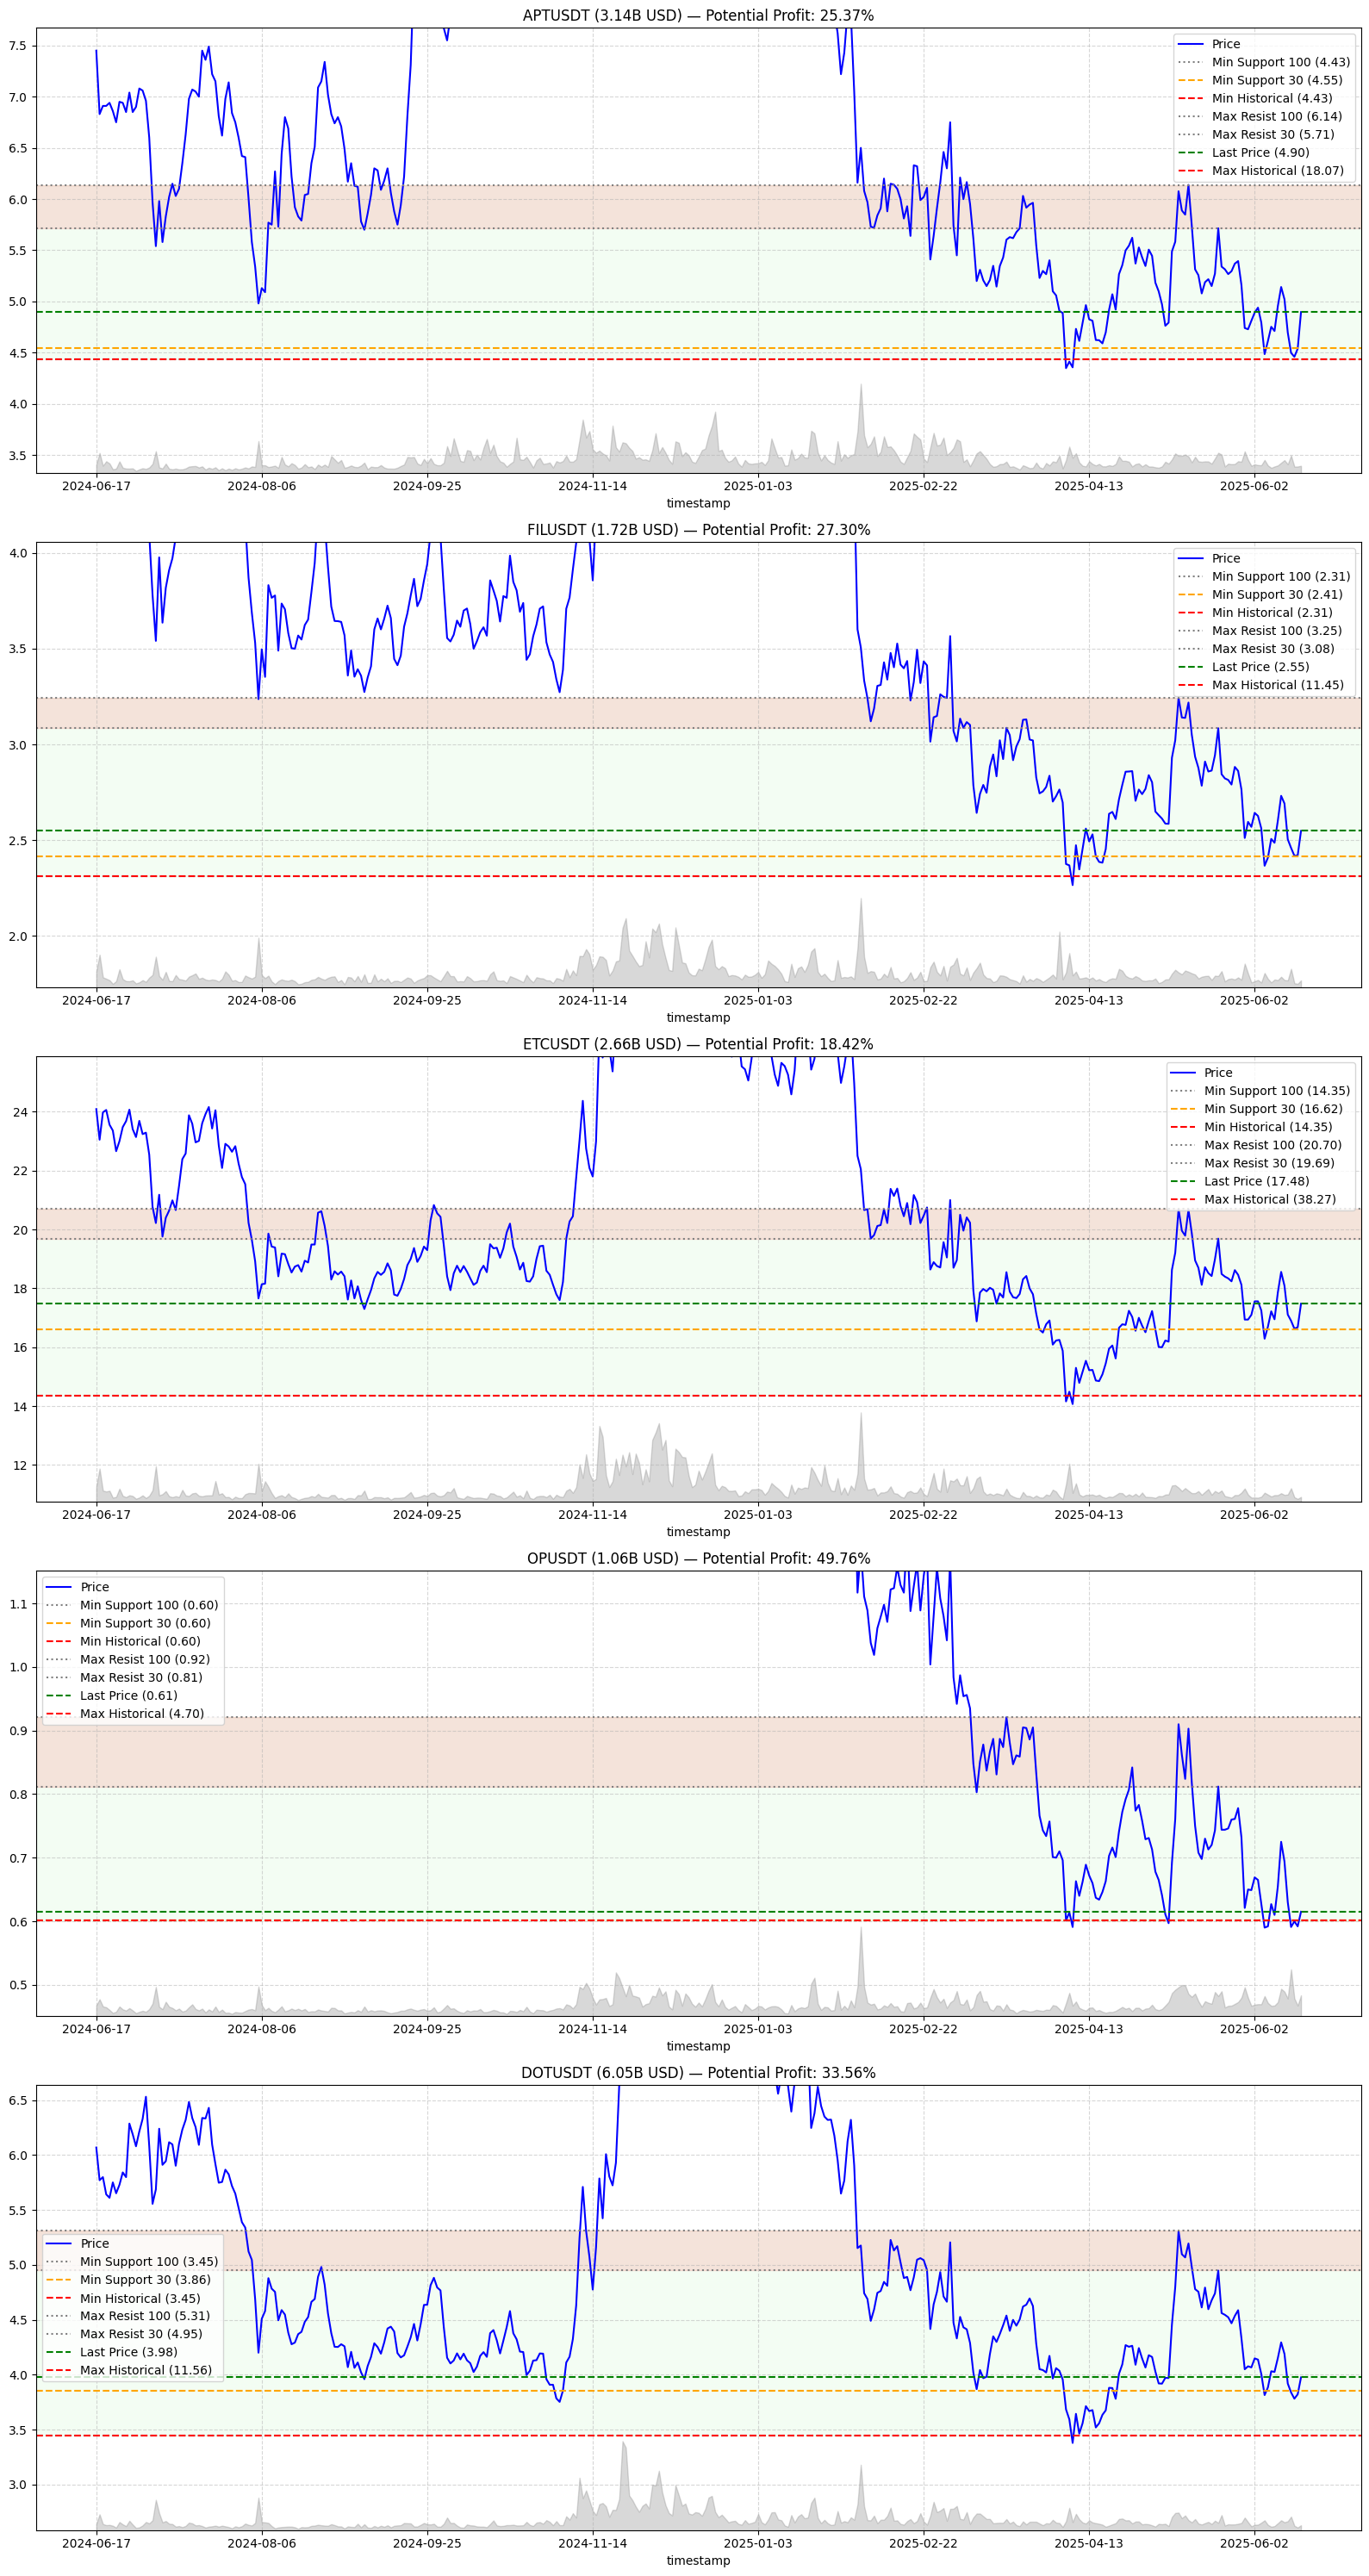

In [31]:
paint_result(df, result, optimal_symbol, cap_df, df_vol, last_days=365)

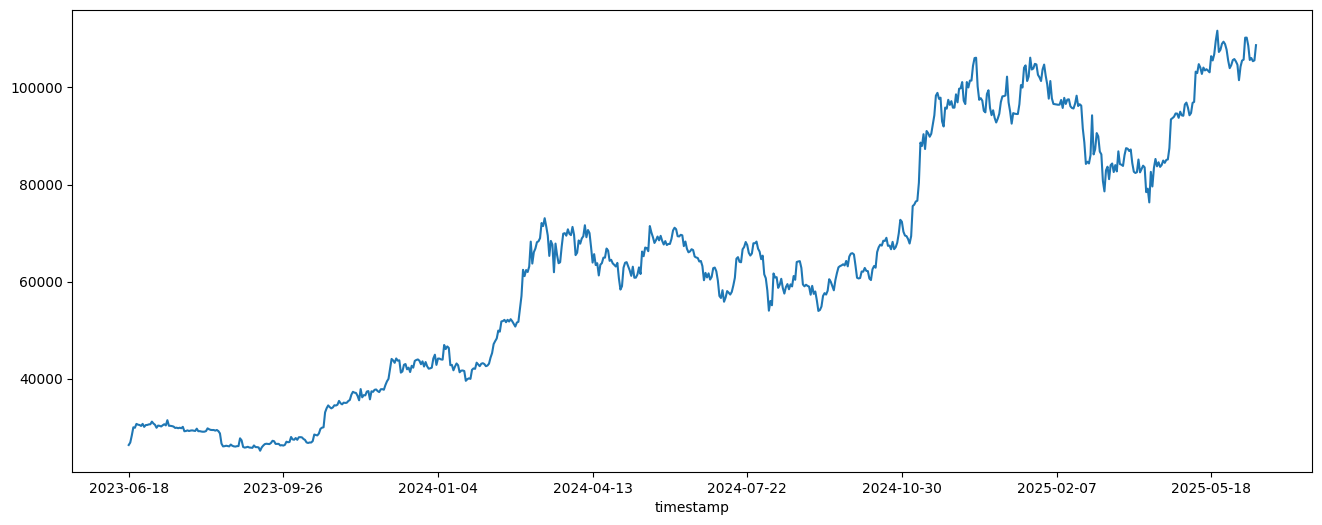

In [14]:
plt.figure(figsize=(16, 6))
df['BTCUSDT'].plot()
plt.show()